In [361]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import numpy as np
from numpy import random
from tqdm import tqdm
import matplotlib.pyplot as plt

In [362]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using mps device


In [378]:
N = 3
k1 = 2**N
L_enc = 7
L_dec = 9
I_dec = 3
N_enc = 2*k1
N_dec = 2*k1
n1 = 2*k1

encoder_learning_rate = 2e-4
decoder_learning_rate = 2e-4
snr = 4

In [379]:
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()

        layers = []

        layers.append(nn.Linear(k1, N_enc))
        layers.append(nn.SELU())
        for i in range(L_enc):
            layers.append(nn.Linear(N_enc, N_enc))
            layers.append(nn.SELU())
        layers.append(nn.Linear(N_enc, n1))

        #layers.append(nn.Tanh())

        self.fcnn = nn.Sequential(
            *layers
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.fcnn(x)
        return logits

In [380]:
class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()

        # it's a set of layers of one decoder out of I_dec decoders
        layers = []
        
        layers.append(nn.Linear(n1, N_dec))
        layers.append(nn.SELU())
        for i in range(L_dec):
            layers.append(nn.Linear(N_dec, N_dec))
            layers.append(nn.SELU())
        layers.append(nn.Linear(N_dec, k1))

        # first decoder 
        # layers.append(nn.Linear(n1, N_dec))
        # layers.append(nn.SELU())
        
        # for i in range(L_enc):
        #     layers.append(nn.Linear(N_dec, N_dec))
        #     layers.append(nn.SELU())
        
        # # second & third decoders
        # for j in range(2):
        #     for i in range(L_enc + 1):
        #         layers.append(nn.Linear(N_dec, N_dec))
        #         layers.append(nn.SELU())

        # # last decoder
        # for i in range(L_enc):
        #     layers.append(nn.Linear(N_dec, N_dec))
        #     layers.append(nn.SELU())
        # layers.append(nn.Linear(N_dec, k1))
        
        #layers.append(nn.Tanh())

        self.fcnn = nn.Sequential(
            *layers
        )
        
    def forward(self, x):
        x = self.flatten(x)
        logits = self.fcnn(x)
        return logits

In [381]:
class PowerNormaliser:
    def normalize(self, tensor):
        #print(tensor.shape)
        norm = torch.norm(tensor, dim=1, p=2)
        normalized_vector = (tensor.T / norm).T
        return normalized_vector

In [382]:
a = torch.tensor([[1, 2, 3, 4], [4, 5, 6, 8]], dtype=torch.float32)
p = PowerNormaliser()
print(p.normalize(a))

tensor([[0.1826, 0.3651, 0.5477, 0.7303],
        [0.3369, 0.4211, 0.5053, 0.6737]])


In [383]:
class Channel():
    def add_noise(self, data, snr=1e10):
        sigma = 10**(-snr/10)
        noise = random.normal(0, sigma, data.shape)
        return data + torch.from_numpy(noise).to(dtype=torch.float32)

In [384]:
class Binarise():
    def __init__(self):
        self.threshold = 0
    def binarise(self, data):
        return (data > self.threshold).float()

In [385]:
encoder = Encoder()
awgn_channel = Channel()
decoder = Decoder()
normaliser = PowerNormaliser()
binarise = Binarise()

In [386]:
enc_optimizer = torch.optim.Adam(encoder.parameters(), lr = encoder_learning_rate)
#enc_scheduler = torch.optim.lr_scheduler.ExponentialLR(enc_optimizer, gamma=0.95)
dec_optimizer = torch.optim.Adam(decoder.parameters(), lr = decoder_learning_rate)
#dec_scheduler = torch.optim.lr_scheduler.ExponentialLR(dec_optimizer, gamma=0.95)
loss_fn = nn.BCEWithLogitsLoss()

In [387]:
num_samples = 2**k1
training_epochs = 100
num_epochs = 1000
batch_size = 64

# x_train = torch.rand((num_samples, k1))
# y_train = x_train
# dataset = torch.utils.data.TensorDataset(x_train, y_train)
# train_loader = DataLoader(dataset, batch_size=batch_size)

In [388]:
#torch.randint(low = -1, high = )

In [389]:
# implement the training loop for the encoder part
# at the same time the decoder part is frozen
# the code should use train_loader to get the data
# and the loss function should be loss_fn
fl = True
for i in range(training_epochs):
#for i in range(1):
    # generate random data for training
    x_train = torch.randint(low=0, high=2, size=(num_samples, k1)).to(dtype=torch.float32)
    y_train = x_train
    dataset = torch.utils.data.TensorDataset(x_train, y_train)
    train_loader = DataLoader(dataset, batch_size=batch_size)

    # implement the training loop for the decoder part
    # at the same time the encoder part is frozen
    # the code should use train_loader to get the data
    # and the loss function should be loss_fn
    
    for epoch in range(300):
        for x_batch, y_batch in train_loader:
            dec_optimizer.zero_grad()
            
            encoded = encoder(x_batch)
            enc_norm = normaliser.normalize(encoded)
            enc_norm_noise = awgn_channel.add_noise(enc_norm, snr)
            
            decoded = decoder(enc_norm_noise)
            # decoded_bin = binarise.binarise(decoded) - Can't do binarise here, because it's a part of the loss function
            
            loss = loss_fn(decoded, y_batch)
            loss.backward()
            dec_optimizer.step()
            
            #print(f"{epoch=}, loss={loss.item():.4f}")

    print(f"Decoder training, loss: {loss.item():.4f}, epoch: {i}")
    
    
    x_train = torch.randint(low=0, high=2, size=(num_samples, k1)).to(dtype=torch.float32)
    y_train = x_train
    dataset = torch.utils.data.TensorDataset(x_train, y_train)
    train_loader = DataLoader(dataset, batch_size=batch_size)
    
    for epoch in range(100):
        for x_batch, y_batch in train_loader:
            enc_optimizer.zero_grad()
            
            encoded = encoder(x_batch)
            enc_norm = normaliser.normalize(encoded)
            enc_norm_noisy = awgn_channel.add_noise(enc_norm, snr)
            
            decoded = decoder(enc_norm_noisy)
            
            loss = loss_fn(decoded, y_batch)
            loss.backward()
            enc_optimizer.step()
        
    print(f"Encoder training, loss: {loss.item():.4f}, epoch: {i}")
    print() 


Decoder training, loss: 0.6949, epoch: 0
Encoder training, loss: 0.6444, epoch: 0

Decoder training, loss: 0.5880, epoch: 1
Encoder training, loss: 0.5695, epoch: 1

Decoder training, loss: 0.5488, epoch: 2
Encoder training, loss: 0.5493, epoch: 2

Decoder training, loss: 0.5222, epoch: 3
Encoder training, loss: 0.5499, epoch: 3

Decoder training, loss: 0.5396, epoch: 4
Encoder training, loss: 0.5578, epoch: 4

Decoder training, loss: 0.5309, epoch: 5
Encoder training, loss: 0.5475, epoch: 5

Decoder training, loss: 0.5466, epoch: 6
Encoder training, loss: 0.5571, epoch: 6

Decoder training, loss: 0.5519, epoch: 7
Encoder training, loss: 0.5730, epoch: 7

Decoder training, loss: 0.5458, epoch: 8
Encoder training, loss: 0.5555, epoch: 8

Decoder training, loss: 0.5608, epoch: 9
Encoder training, loss: 0.5367, epoch: 9

Decoder training, loss: 0.5583, epoch: 10
Encoder training, loss: 0.5479, epoch: 10

Decoder training, loss: 0.5552, epoch: 11
Encoder training, loss: 0.5456, epoch: 11



In [390]:
class BER:
    def __init__(self):
        self.threshold = 0
    def ber(self, data, data_hat):
        return torch.mean((data != data_hat).float())

In [391]:
ber = BER()
ber_arr = []
snr_db = np.arange(0, 10, 0.5)

for snr in snr_db:
    x_test = torch.randint(low=0, high=2, size=(num_samples, k1)).to(dtype=torch.float32)
    y_test = x_test

    encoded = encoder(x_test)
    enc_norm = normaliser.normalize(encoded)
    enc_norm_noisy = awgn_channel.add_noise(enc_norm, snr)
    decoded = decoder(enc_norm_noisy)
    decoded_bin = binarise.binarise(decoded)
    ber_arr.append(ber.ber(y_test, decoded_bin))

    print(f"SNR: {snr:.2f} | BER: {ber.ber(y_test, decoded_bin)}")

SNR: 0.00 | BER: 0.41748046875
SNR: 0.50 | BER: 0.38037109375
SNR: 1.00 | BER: 0.3759765625
SNR: 1.50 | BER: 0.4033203125
SNR: 2.00 | BER: 0.38232421875
SNR: 2.50 | BER: 0.36279296875
SNR: 3.00 | BER: 0.36669921875
SNR: 3.50 | BER: 0.3447265625
SNR: 4.00 | BER: 0.34619140625
SNR: 4.50 | BER: 0.33740234375
SNR: 5.00 | BER: 0.31494140625
SNR: 5.50 | BER: 0.322265625
SNR: 6.00 | BER: 0.3359375
SNR: 6.50 | BER: 0.30419921875
SNR: 7.00 | BER: 0.30322265625
SNR: 7.50 | BER: 0.3115234375
SNR: 8.00 | BER: 0.3173828125
SNR: 8.50 | BER: 0.298828125
SNR: 9.00 | BER: 0.31689453125
SNR: 9.50 | BER: 0.3173828125


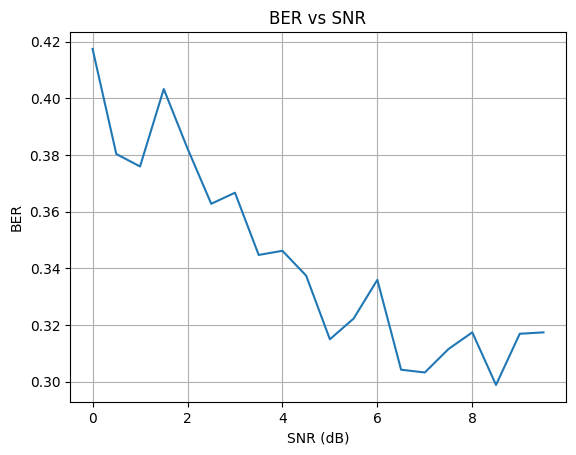

In [392]:
plt.plot(snr_db, ber_arr)
plt.xlabel('SNR (dB)')
plt.ylabel('BER')
plt.grid()
plt.title('BER vs SNR')
plt.show()